# Definindo a Action Network

In [19]:
import torch
from torch.nn import ModuleList, Linear, ReLU, Sequential, Softmax
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import softmax

class ActionNetwork(MessagePassing):
    def __init__(self, in_channels, hidden_dim, num_hidden_layers, out_channels=4):
        """
        Inicializa a rede de ação para CO-GNN.

        Parâmetros:
            in_channels (int): Dimensão de entrada dos estados dos nós.
            hidden_dim (int): Dimensão das camadas ocultas.
            num_hidden_layers (int): Número de camadas ocultas na rede.
            out_channels (int): Número de ações possíveis, padrão é 4 (S, L, B, I).
        """
        super(ActionNetwork, self).__init__(aggr='mean')  # Usando agregação média por padrão.
        
        self.layers = ModuleList()
        
        # Primeira camada oculta que transforma a entrada para a dimensão oculta.
        self.layers.append(Linear(in_channels, hidden_dim))
        self.layers.append(ReLU())

        # Camadas ocultas intermediárias.
        for _ in range(num_hidden_layers - 1):
            self.layers.append(Linear(hidden_dim, hidden_dim))
            self.layers.append(ReLU())

        # Camada de saída que mapeia a última camada oculta para as ações.
        self.layers.append(Linear(hidden_dim, out_channels))
        self.softmax = Softmax(dim=1)

    def forward(self, x, edge_index):
        """
        Propagação para frente que processa os estados dos nós e retorna as probabilidades das ações.

        Parâmetros:
            x (Tensor): Estados dos nós com shape [num_nodes, in_channels].
            edge_index (LongTensor): Índices das arestas no formato COO (2, num_edges).

        Retorna:
            Tensor: Probabilidades das ações para cada nó com shape [num_nodes, out_channels].
        """
        return self.propagate(edge_index, size=(x.size(0), x.size(0)), x=x)

    def message(self, x_j):
        """
        Cria mensagens para serem enviadas aos nós centrais na agregação.

        Parâmetros:
            x_j (Tensor): Estados dos nós vizinhos.
        
        Retorna:
            Tensor: Mensagens enviadas aos nós.
        """
        for layer in self.layers:
            x_j = layer(x_j) if not isinstance(layer, ReLU) else layer(x_j)
        return x_j

    def update(self, aggr_out):
        """
        Atualiza os estados dos nós depois da agregação.

        Parâmetros:
            aggr_out (Tensor): Saída da agregação das mensagens dos vizinhos.

        Retorna:
            Tensor: Probabilidades das ações atualizadas com softmax aplicado.
        """
        return self.softmax(aggr_out)


## Testando a Action Network

In [20]:
import torch
from torch_geometric.data import Data

# Criar dados de exemplo para o grafo
num_nodes = 4  # número de nós no grafo
num_node_features = 3  # número de características por nó

# Estados dos nós: tensor aleatório [num_nodes, num_node_features]
x = torch.rand((num_nodes, num_node_features))

# Conexões (arestas) entre os nós: formato COO (2, num_edges)
edge_index = torch.tensor([[0, 1, 2, 3, 0, 2],
                           [1, 0, 3, 2, 2, 0]], dtype=torch.long)

# Criar instância da ActionNetwork
action_net = ActionNetwork(in_channels=num_node_features, hidden_dim=5, num_hidden_layers=2)

# Passar os dados pelo modelo
action_probabilities = action_net(x, edge_index)

# Imprimir as probabilidades das ações para cada nó
print("Probabilidades das Ações para cada nó:")
print(action_probabilities)


Probabilidades das Ações para cada nó:
tensor([[0.1894, 0.1874, 0.2964, 0.3268],
        [0.1866, 0.1871, 0.2893, 0.3370],
        [0.1868, 0.1853, 0.2882, 0.3397],
        [0.1888, 0.1882, 0.2965, 0.3265]], grad_fn=<SoftmaxBackward0>)


# Definindo a Environment Network

In [26]:
import torch
from torch.nn import ModuleList, Linear, GELU
from torch_geometric.nn import GCNConv

class EnvironmentNetwork(torch.nn.Module):
    def __init__(self, in_channels, hidden_dim, out_channels, num_layers):
        """
        Inicializa a rede de ambiente para a CO-GNN.
        
        Parâmetros:
            in_channels (int): Número de características de entrada por nó.
            hidden_dim (int): Dimensão das camadas ocultas.
            out_channels (int): Dimensão da camada de saída.
            num_layers (int): Número de camadas GCN na rede.
        
        A rede usa camadas GCN seguidas de funções de ativação GELU.
        """
        super(EnvironmentNetwork, self).__init__()
        self.layers = ModuleList()
        
        self.layers.append(GCNConv(in_channels, hidden_dim))

        # Camadas GCN ocultas intermediárias
        for _ in range(num_layers - 2):
            self.layers.append(GCNConv(hidden_dim, hidden_dim))
        
        # Camada GCN final para transformar para a dimensão de saída
        if num_layers > 1:
            self.layers.append(GCNConv(hidden_dim, out_channels))
        else:
            # Se houver apenas uma camada, mapeie diretamente da entrada para a saída
            self.layers.append(GCNConv(in_channels, out_channels))
        
        # Função de ativação GELU após cada camada GCN, exceto a última
        self.activation = GELU()

    def forward(self, x, edge_index):
        """
        Propagação para frente da rede de ambiente.

        Parâmetros:
            x (Tensor): Características dos nós, shape [num_nodes, num_features].
            edge_index (Tensor): Arestas do grafo no formato COO, shape [2, num_edges].

        Retorna:
            Tensor: Representações dos nós atualizadas após L camadas, shape [num_nodes, out_channels].
    
        """
        for layer in self.layers[:-1]:
            x = self.activation(layer(x, edge_index))
        
        # Apply the last layer without activation to get the final output dimensions
        x = self.layers[-1](x, edge_index)
        return x


## Testando a environment network

In [29]:
import torch
from torch_geometric.data import Data

# Assume that ActionNetwork and EnvironmentNetwork are already imported and available

# Define a simple graph
num_nodes = 4
num_features = 3
x = torch.rand((num_nodes, num_features))  # Random features for nodes
edge_index = torch.tensor([[0, 1, 2, 3, 0, 2], [1, 0, 3, 2, 2, 0]], dtype=torch.long)  # Edges in COO format

print("Node Features:")
print(x)
print("Edge Index:")
print(edge_index)

# Instantiate the networks (assuming appropriate parameters)
action_net = ActionNetwork(in_channels=num_features, hidden_dim=5, num_hidden_layers=2, out_channels=4)
env_net = EnvironmentNetwork(in_channels=num_features, hidden_dim=5, out_channels=num_features, num_layers=2)

# Forward pass through the action network to get action probabilities
action_probabilities = action_net(x, edge_index)

# chosing the action with the highest probability for each node
_, actions = action_probabilities.max(dim=1)

print("Actions chosen for each node:")
print(actions)

# Assume we have predefined actions based on an external decision or prior knowledge
# Actions: Standard (S=0), Listen (L=1), Broadcast (B=2), Isolate (I=3)
# actions = torch.tensor([0, 1, 2, 3])  # One action per node

# Define a mapping function for actions to neighbors
def get_neighbors_to_consider(edge_index, actions):
    mask = (actions[edge_index[1]] == 0) | (actions[edge_index[1]] == 2)  # Consider if action is S or B
    new_edge_index = edge_index[:, mask]
    return new_edge_index

# Apply the environment network with the selected actions
new_edge_index = get_neighbors_to_consider(edge_index, actions)
updated_x = env_net(x, new_edge_index)

# Print the updated node features
print("Updated node features:")
print(updated_x)


Node Features:
tensor([[0.3536, 0.8208, 0.5109],
        [0.5799, 0.3828, 0.7297],
        [0.4599, 0.9076, 0.8699],
        [0.8516, 0.0352, 0.0850]])
Edge Index:
tensor([[0, 1, 2, 3, 0, 2],
        [1, 0, 3, 2, 2, 0]])
Actions chosen for each node:
tensor([1, 1, 1, 1])
Updated node features:
tensor([[-0.5538, -0.1786,  0.2570],
        [-0.2217, -0.0739,  0.0952],
        [-0.5823, -0.1676,  0.2849],
        [-0.0650,  0.0009,  0.2418]], grad_fn=<AddBackward0>)


# CO-GNN

## Testando interação entre as duas redes sem usar a Gumbel Softmax

In [31]:
import torch
from torch_geometric.data import Data

class CO_GNN(torch.nn.Module):
    def __init__(self, action_network, environment_network):
        """
        Initialize the Cooperative Graph Neural Network (CO-GNN) which uses two GNNs:
        (i) An action network (π) for choosing the best actions.
        (ii) An environment network (η) for updating the node representations.

        Parameters:
            action_network (torch.nn.Module): The GNN to determine actions.
            environment_network (torch.nn.Module): The GNN to update node states based on actions.
        """
        super(CO_GNN, self).__init__()
        self.action_network = action_network
        self.environment_network = environment_network

    def forward(self, data):
        """
        Forward pass of the CO-GNN layer.

        Parameters:
            data (Data): A PyTorch Geometric Data object containing:
                         - x (Tensor): Node features.
                         - edge_index (Tensor): Graph connectivity in COO format.

        Returns:
            Tensor: Updated node representations.
        """
        x, edge_index = data.x, data.edge_index

        # Step 1: Action network predicts the probability distribution over actions
        action_probs = self.action_network(x, edge_index)
        
        # Step 2: Sample actions using argmax for simplicity (instead of straight-through Gumbel-Softmax)
        actions = torch.argmax(action_probs, dim=1)
        
        # Determine neighbors to consider based on the actions sampled
        mask = (actions[edge_index[0]] == 0) | (actions[edge_index[0]] == 2)  # Only neighbors with S (0) or B (2)
        new_edge_index = edge_index[:, mask]

        # Step 3: Update node states based on actions
        updated_x = self.environment_network(x, new_edge_index)

        return updated_x


In [32]:
# Assume that action_net and env_net have been defined and instantiated appropriately
# Example:
action_net = ActionNetwork(in_channels=3, hidden_dim=5, num_hidden_layers=2, out_channels=4)
env_net = EnvironmentNetwork(in_channels=3, hidden_dim=5, out_channels=3, num_layers=2)

co_gnn = CO_GNN(action_network=action_net, environment_network=env_net)
data = Data(x=torch.rand(4, 3), edge_index=torch.tensor([[0, 1, 2, 3, 0, 2], [1, 0, 3, 2, 2, 0]], dtype=torch.long))
updated_features = co_gnn(data)
print(updated_features)


tensor([[-0.2282, -0.3109,  0.1727],
        [-0.2278, -0.2887,  0.1922],
        [-0.1495, -0.1961,  0.1290],
        [-0.0789, -0.1120,  0.0698]], grad_fn=<AddBackward0>)


## Versão final da CO-GNN (treinável e com Gumbel Softmax)

In [33]:
import torch
from torch_geometric.data import Data
import torch.nn.functional as F

def gumbel_softmax(logits, tau=1.0, hard=False, dim=-1):
    """
    Amostragem Gumbel-Softmax para ações discretas.
    """
    gumbels = -torch.empty_like(logits).exponential_().log()  # Amostras Gumbel
    gumbels = (logits + gumbels) / tau  # Aplica a temperatura tau
    y_soft = gumbels.softmax(dim)

    if hard:
        # Straight-through Gumbel-Softmax
        index = y_soft.max(dim, keepdim=True)[1]
        y_hard = torch.zeros_like(logits).scatter_(dim, index, 1.0)
        ret = y_hard - y_soft.detach() + y_soft
    else:
        ret = y_soft
    return ret

class CO_GNN(torch.nn.Module):
    def __init__(self, action_network, environment_network, tau=1.0):
        super(CO_GNN, self).__init__()
        self.action_network = action_network
        self.environment_network = environment_network
        self.tau = tau  # Temperatura Gumbel-Softmax

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        action_logits = self.action_network(x, edge_index)
        actions = gumbel_softmax(action_logits, tau=self.tau, hard=True) 

        # Filtrar arestas com base nas ações (Padrão ou Transmissão)
        actions_argmax = actions.argmax(dim=1)
        mask = (actions_argmax[edge_index[0]] == 0) | (actions_argmax[edge_index[0]] == 2)
        new_edge_index = edge_index[:, mask]

        updated_x = self.environment_network(x, new_edge_index)
        return updated_x


## Verificando se é possível fazer backpropagation

In [84]:
torch.manual_seed(123)
x = torch.randn(4, 3, requires_grad=True)
edge_index = torch.tensor([[0, 1, 2, 3, 0, 2], [1, 0, 3, 2, 2, 0]], dtype=torch.long)

action_net = ActionNetwork(in_channels=3, hidden_dim=5, num_hidden_layers=2, out_channels=4)
env_net = EnvironmentNetwork(in_channels=3, hidden_dim=5, out_channels=3, num_layers=2)
co_gnn = CO_GNN(action_network=action_net, environment_network=env_net)

data = Data(x=x, edge_index=edge_index)
out = co_gnn(data)
loss = out.sum()
loss.backward()

print("Gradients on input features:", x.grad)


Gradients on input features: tensor([[-0.1913,  0.0660, -0.1566],
        [-2.1367,  0.7625, -1.8029],
        [-0.3467,  0.1069, -0.2718],
        [-0.2368,  0.0677, -0.1352]])


# Avaliando o modelo

## Carregando dataset para avaliar o modelo

In [99]:
import torch
from torch_geometric.data import Data

# Load the data
data, _ = torch.load("roman_empire.pt")

# Use only the first 10 features of each node
data.x = data.x[:, :300]

# Checking the dataset
print(data)




Data(x=[22662, 300], edge_index=[2, 32927], y=[22662], train_mask=[22662, 10], val_mask=[22662, 10], test_mask=[22662, 10])


## Definindo as redes

In [103]:
num_features = 300  # Updated number of features
num_classes = data.y.max().item() + 1  # Number of classes for the classification task

# Redefine the action and environment networks
action_net = ActionNetwork(in_channels=num_features, hidden_dim=4, num_hidden_layers=2, out_channels=4)
env_net = EnvironmentNetwork(in_channels=num_features, hidden_dim=32, out_channels=num_classes, num_layers=4)
model = CO_GNN(action_network=action_net, environment_network=env_net)


## Fazendo treino e teste

In [104]:

import torch.optim as optim
from torch.nn.functional import cross_entropy

optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)

def train(model, data, mask_index=0):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    # Use only the first mask (if that's the correct one to use)
    loss = cross_entropy(out[data.train_mask[:, mask_index]], data.y[data.train_mask[:, mask_index]])
    loss.backward()
    optimizer.step()
    return loss.item()

def evaluate(model, data, mask_index=0):
    model.eval()
    with torch.no_grad():
        out = model(data)
        pred = out.argmax(dim=1)
        train_acc = pred[data.train_mask[:, mask_index]].eq(data.y[data.train_mask[:, mask_index]]).sum().item() / data.train_mask[:, mask_index].sum().item()
        val_acc = pred[data.val_mask[:, mask_index]].eq(data.y[data.val_mask[:, mask_index]]).sum().item() / data.val_mask[:, mask_index].sum().item()
        test_acc = pred[data.test_mask[:, mask_index]].eq(data.y[data.test_mask[:, mask_index]]).sum().item() / data.test_mask[:, mask_index].sum().item()
    return train_acc, val_acc, test_acc

losses = []

# You can now run the training and evaluation loop:
for epoch in range(5000):
    loss = train(model, data)
    losses.append(loss)
    train_acc, val_acc, test_acc = evaluate(model, data)
    print(f'Epoch {epoch+1}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}                                      ', end='\r')




## Plotando a evolução da Loss

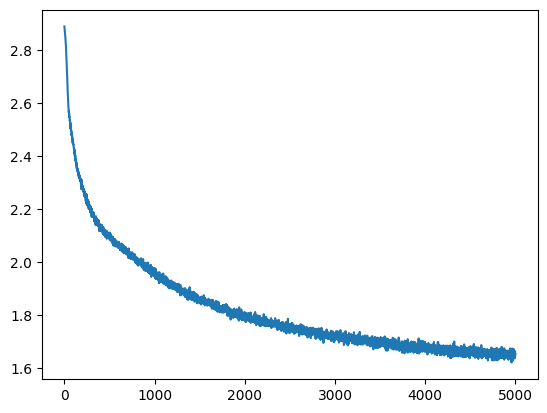

In [105]:
import matplotlib.pyplot as plt

plt.plot(losses)